# TA Analysis
Target acquisition (TA) is a procedure that centroids a source and precisely places it within an aperture or subarray. To better measure the location of the star with respect to the coronagraph, we can use the TA to make adjustments. In this notebook, we demonstrate how the `recenter_frames_ta` in SpaceKLIP's image manipulation tools class, ImageTools, uses TA data to calculate and apply the necessary offsets.


## Import Library

In [1]:
%load_ext autoreload
%autoreload 2
    
from astropy.io import fits
from jwst.tweakreg.utils import adjust_wcs
import jwst.datamodels as datamodels
import numpy as np
import astropy
import astropy.units as u
import matplotlib.pyplot as plt

import spaceKLIP
import spaceKLIP.engdb as engdb
import spaceKLIP.utils as utils
import spaceKLIP.target_acq_tools as target_acq_tools

2024-12-11 14:03:41,648 - stpipe - WARNING - **WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-067 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-068
--- Logging error ---
Traceback (most recent call last):
  File "/Users/kglidic/miniconda3/envs/sklip_n/lib/python3.11/logging/__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "/Users/kglidic/miniconda3/envs/sklip_n/lib/python3.11/logging/__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "/Users/kglidic/miniconda3/envs/sklip_n/lib/python3.11/logging/__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "/Users/kglidic/miniconda3/envs/sklip_n/lib/python3.11/logging/__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File "<frozen runpy>", line 198, in _run_m

Let's walk through the re-centering routine using an example image to demonstrate how we can more precisely estimate the star's position behind the coronagraph. We'll start by defining the path to a calibrated product from Stage 2:














In [2]:
cal_product = './spaceKLIP/docs/source/tutorials/data_nircam_hd65426/stage2/jw01386001001_0310e_00009_nrcalong_calints.fits'

Now that we have the path to a calibrated product, let’s extract some key information from the FITS header, like the visit ID, instrument to query MAST for the TA images associated with this visit. 

In [3]:
visitid = 'V'+fits.getval(cal_product, 'VISIT_ID')
instrument = fits.getval(cal_product, 'INSTRUME')

In [4]:
# Images are saved in memory not to disk.
ta_images = target_acq_tools.get_visit_ta_image(visitid, inst=instrument)

Querying MAST for target acquisition files for visit V01386001001
Found 1 target acquisition image(s) for this observation.
TA file: jw01386001001_02102_00001_nrcalong_cal.fits


In this example, there is only one TA image associated with the visit. However, visits can include multiple TA images. Here, we’ll plot this single example TA image. 

The `show_ta_img` function below takes the visit ID and instrument name as inputs, allowing us to specify which TA image to display if multiple are available. It also includes the option to mark the SIAF reference point, which indicates the intended position of the target within the aperture's field of view. 

In addition to displaying the TA image, the function optionally returns handles, which we will use later to add additional details to the plot.


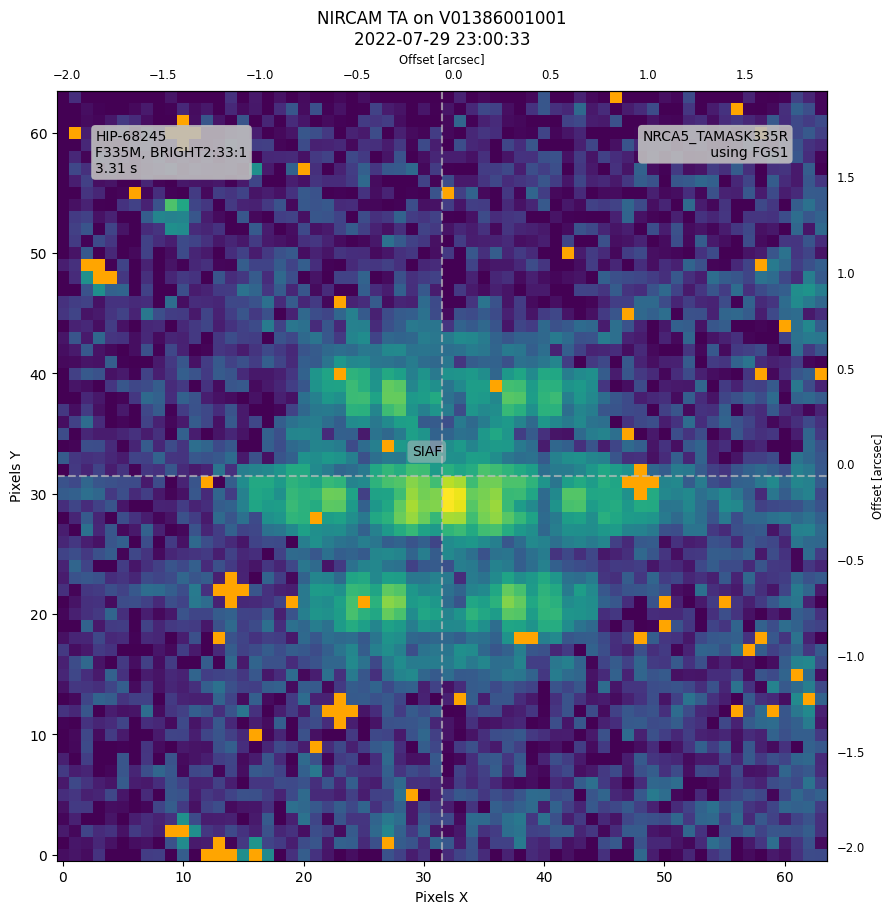

In [5]:
# Plot the TA image(s).
ta_image_hdul, ax, norm, cmap, bglevel = target_acq_tools.show_ta_img(visitid, 
                                                                      inst=instrument,
                                                                      return_handles=True,
                                                                      ta_expnum=None, # required if multiple images in visit.
                                                                      mark_reference_point=True,
                                                                      mark_apername=True,
                                                                      zoom_region=False)

In the plot above, the SIAF reference point is clearly marked by the gray hash lines. To be thorough, let’s work through how we obtained this reference point.


In [6]:
# Retrieve the TA aperture and reference point.

siaf = utils.get_siaf(instrument)
ta_aperture = siaf.apertures[ta_image_hdul[0].header['APERNAME']]
print(f"The TA aperture is {ta_aperture.AperName}")  # This should match the label in the plots above.

xref, yref = ta_aperture.XSciRef - 1, ta_aperture.YSciRef - 1  # 1-indexed
print (f"Intended Target Position (from SIAF) = {xref, yref} pix")

The TA aperture is NRCA5_TAMASK335R
Intended Target Position (from SIAF) = (31.5, 31.5) pix


The centroid calculated during TA is performed in real time onboard the spacecraft and is recorded in the Onboard Science Software (OSS) log. This information is not included in the science data products, so to access the centroid data, we must retrieve the corresponding OSS log. We use the `engdb.get_ictm_event_log` function to do so. This function queries the engineering database for a specific event log within the time range of the TA observation. The start and end times of the TA are extracted from the FITS header (VSTSTART and VISITEND) and passed as arguments. 














In [7]:
ta_start = ta_image_hdul[0].header['VSTSTART']
ta_end = ta_image_hdul[0].header['VISITEND']

osslog = engdb.get_ictm_event_log(ta_start, ta_end)
osslog  # Returns a table of lines from the log.

Time,MJD,Message
str26,float64,str80
2022-07-29 22:01:47.391000,59789.9179096181,VISIT V01176241001 ENDED
2022-07-29 22:01:51.487000,59789.9179570255,VISIT V01386001001 STARTED
2022-07-29 22:02:00.703000,59789.9180636921,Script activated: V01386001001:CONVST
2022-07-29 22:02:02.751000,59789.9180873958,Script terminated: V01386001001:CONVST:Proceed
2022-07-29 22:02:04.799000,59789.9181110995,Group V01386001001:01 started
2022-07-29 22:02:05.823000,59789.9181229514,Seq V01386001001:P00000000:01:1 started
2022-07-29 22:02:07.871000,59789.9181466551,Script activated: V01386001001P0000000001101:SCSLEWMAIN
2022-07-29 22:06:39.231000,59789.9212873958,Observation Plan will stop after V01759005001
2022-07-29 22:06:47.423000,59789.9213822106,Script terminated: OPE_REQUEST_STOP_AFTER_VST:OPREQUEST:Proceed


The `engdb.extract_oss_TA_centroids` function processes the retrieved OSS log and isolates the centroid information for the given visit ID. Note however, the OSS does this measurement in full-frame coordinates (2048 x 2048). 

In [8]:
oss_cen = engdb.extract_oss_TA_centroids(osslog, visitid)
print(f"OSS centroid on board (x, y):  {oss_cen}  (full det coord frame, 1-based)")

Extracted date and time: 2022-07-29 23:04:19.32
Datetime object: 2022-07-29 23:04:19.320000
OSS centroid on board (x, y):  (1557.8437, 1548.52431)  (full det coord frame, 1-based)


Lets Convert from full-frame (as used by OSS) to the TA detector subarray coords:


In [9]:
oss_cen_sci = ta_aperture.det_to_sci(*oss_cen)  # Centroid in the subarray coordinate frame.
oss_cen_sci_pythonic = np.asarray(oss_cen_sci) - 1  # Convert from 1-based pixel indexing to 0-based.
print(f"OSS centroid converted (x, y): {oss_cen_sci_pythonic}  (sci frame in {ta_aperture.AperName}, 0-based)")

OSS centroid converted (x, y): [32.1563  29.52431]  (sci frame in NRCA5_TAMASK335R, 0-based)


Now we can add this point to our TA image.

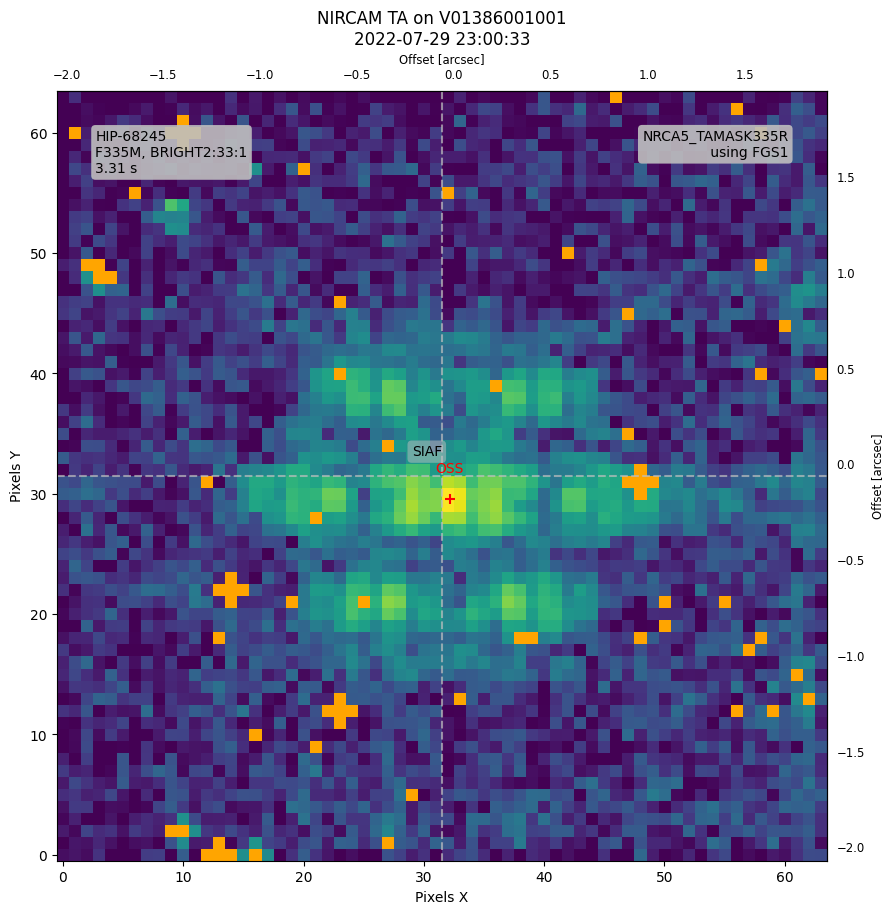

In [10]:
# Update the TA image with the OSS centroid.
fig = ax.get_figure()
ax.scatter(oss_cen_sci_pythonic[0], oss_cen_sci_pythonic[1],
           color='red', marker='+', s=50)
ax.text(oss_cen_sci_pythonic[0], oss_cen_sci_pythonic[1] + 2, 'OSS',
        color='red', verticalalignment='bottom',
        horizontalalignment='center')
fig

Next, we’ll examine the Target Acquisition (TA) World Coordinate System (WCS) to identify where it places the target within the aperture. By comparing this position to the OSS-derived centroid, we can determine the necessary adjustments to align the two points if an offset is present. 














In [11]:
# Create a SkyCoord object for the target coordinates (RA, Dec) in ICRS frame.
ta_model = datamodels.open(ta_image_hdul)

targ_coords = astropy.coordinates.SkyCoord(
    ra=ta_model.meta.target.ra,
    dec=ta_model.meta.target.dec,
    frame='icrs',
    unit=u.deg
)

In [12]:
# Convert celestial coordinates (RA, Dec) to pixel coordinates using WCS.
wcs_ta = ta_model.meta.wcs

targ_coords_pix = wcs_ta.world_to_pixel(targ_coords)  # Returns (x, y).
print(f"Expected from WCS (x, y): ({targ_coords_pix[0]:.2f}, {targ_coords_pix[1]:.2f})")

Expected from WCS (x, y): (39.02, 31.27)


Now we can add this point to our TA image.

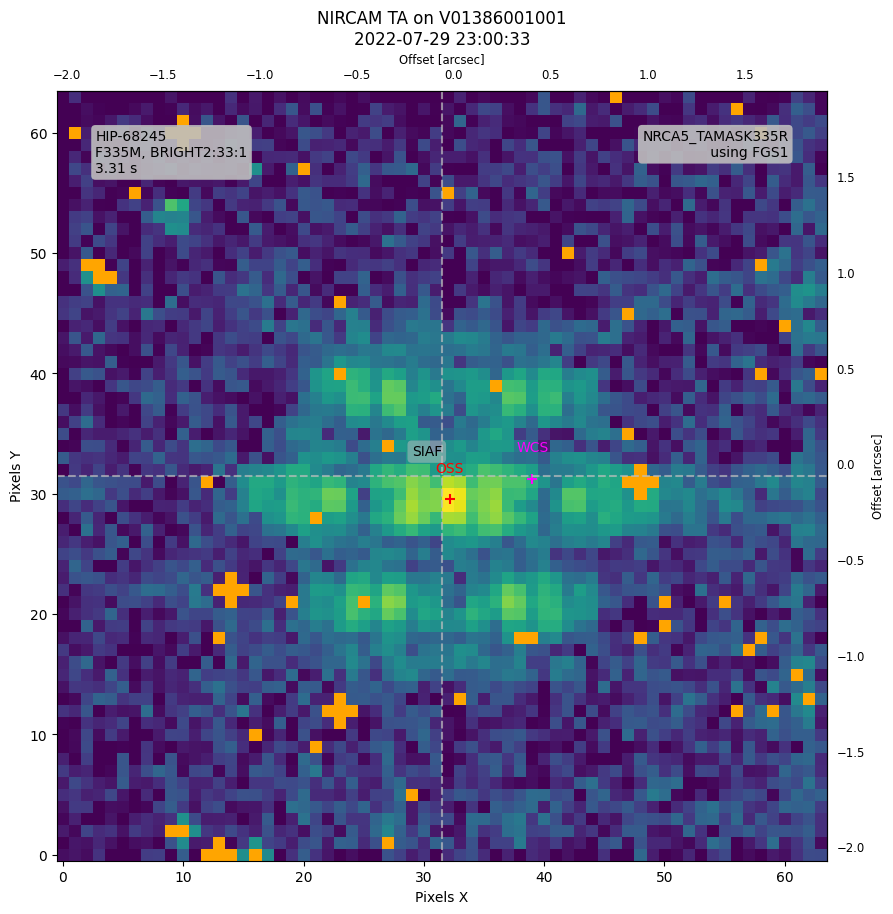

In [13]:
# Update the TA image with the WCS target coordinate.
fig = ax.get_figure()
ax.scatter(targ_coords_pix[0], targ_coords_pix[1],
           color='magenta', marker='+', s=50)
ax.text(targ_coords_pix[0], targ_coords_pix[1] + 2, 'WCS',
        color='magenta', verticalalignment='bottom',
        horizontalalignment='center')
fig

Let's calculate the offsets between the WCS, and OSS centroid and try to adjust the WCS.

In [14]:
# Compute offsets.

# Compute initial delta RA/DEC (WCS to OSS).
# From above, we already have targ_coords as the RA and DEC of the target star at the time of the exposure.
wcs_ta_current = wcs_ta
ta_cen_coords_initial = wcs_ta_current.pixel_to_world(*oss_cen_sci_pythonic)
dra_initial, ddec_initial = ta_cen_coords_initial.spherical_offsets_to(targ_coords)
original_wcs_offset_radec = (dra_initial.to(u.arcsec), ddec_initial.to(u.arcsec))
print(f"Initial TA WCS offset (RA, DEC) =  {original_wcs_offset_radec[0]:.3f}, {original_wcs_offset_radec[1]:.3f} (WCS - OSS)")

# Pixel offset.
wcs_offset_pix = np.asarray(targ_coords_pix) - oss_cen_sci_pythonic  # WCS - OSS
print(f"Initial TA WCS offset (x, y) [pix] =  {wcs_offset_pix[0]:.3f}, {wcs_offset_pix[1]:.3f} (WCS - OSS)")

# Adjust the WCS.
wcs_ta_current = adjust_wcs(wcs_ta_current, *original_wcs_offset_radec)

# Compute the residual offset after adjustment.
targ_coords_pix_adj = wcs_ta_current.world_to_pixel(targ_coords)
targ_coords_adj = wcs_ta_current.pixel_to_world(*targ_coords_pix_adj)
residual_pix = np.asarray(targ_coords_pix_adj) - oss_cen_sci_pythonic
dra_initial, ddec_initial = ta_cen_coords_initial.spherical_offsets_to(targ_coords_adj)
print(f"Residual offset (x, y) [pix] {residual_pix[0]}, {residual_pix[1]}")
print(f"Residual offset (RA, DEC) [arcsec] {dra_initial.to(u.arcsec)}, {ddec_initial.to(u.arcsec)}")

Initial TA WCS offset (RA, DEC) =  0.245 arcsec, 0.364 arcsec (WCS - OSS)
Initial TA WCS offset (x, y) [pix] =  6.865, 1.742 (WCS - OSS)
Residual offset (x, y) [pix] 0.35881669191826404, 0.9608002474917612
Residual offset (RA, DEC) [arcsec] 0.2457690408462163 arcsec, 0.3643110638868981 arcsec


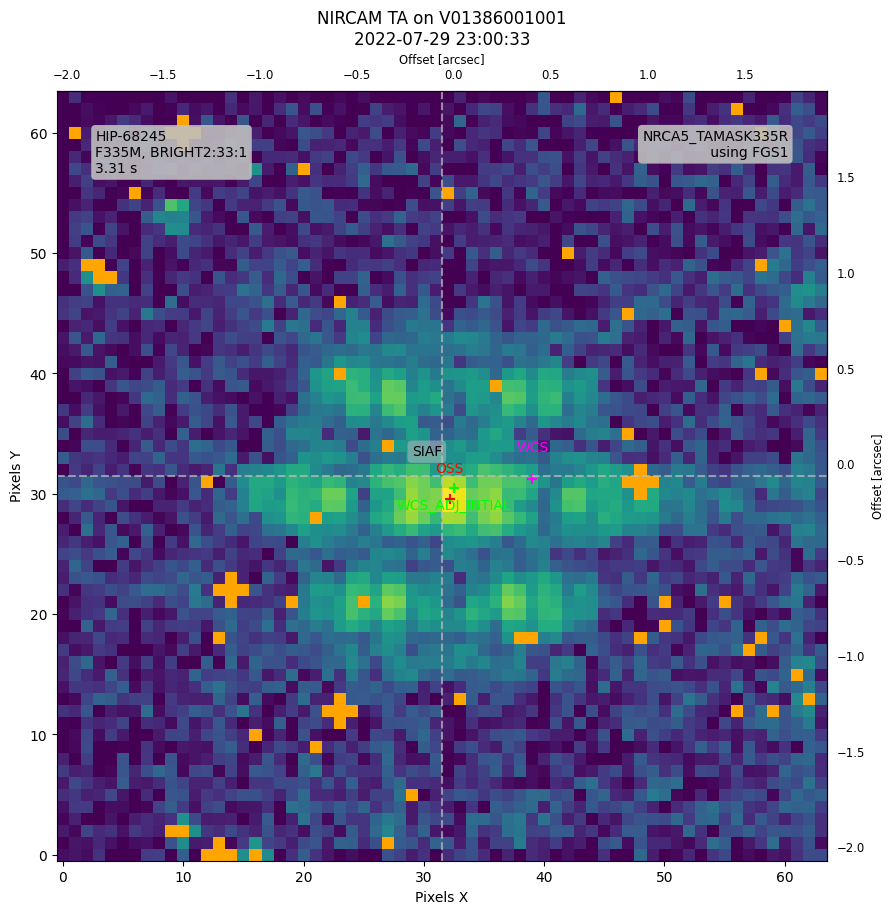

In [15]:
# Update the TA image with the Adjusted WCS target coordinate.
fig = ax.get_figure()
ax.scatter(targ_coords_pix_adj[0], targ_coords_pix_adj[1],
           color='lime', marker='+', s=50)
ax.text(targ_coords_pix_adj[0], targ_coords_pix_adj[1] - 2, 'WCS_ADJ_INTIAL',
        color='lime', verticalalignment='bottom',
        horizontalalignment='center')
fig

This initial adjustment brings the WCS and OSS positions into close alignment. However, I found that for a more precise result, we had to refine the alignment by iteratively adjusting the WCS in a loop. Each iteration reduces residual offsets.








In [16]:
# Compute initial delta RA/DEC (WCS to OSS).
# From above, we already have targ_coords as the RA and DEC of the target star at the time of the exposure.
wcs_ta_current = wcs_ta
ta_cen_coords_initial = wcs_ta_current.pixel_to_world(*oss_cen_sci_pythonic)
dra_initial, ddec_initial = ta_cen_coords_initial.spherical_offsets_to(targ_coords)
original_wcs_offset_radec = (dra_initial.to(u.arcsec), ddec_initial.to(u.arcsec))

wcs_offset_pix = np.asarray(targ_coords_pix) - oss_cen_sci_pythonic  # Offset in pixels (x,y).

# Total offsets.
total_radec_offset = [ddec_initial.to(u.arcsec), dra_initial.to(u.arcsec)]
total_px_offset_x, total_px_offset_y = wcs_offset_pix[0], wcs_offset_pix[1]

# Obtain the initial WCS for the science observation (not TA).
# We will perform the same RA/DEC adjustments to the TA and SCI WCS.
wcs_sci_current = datamodels.open(cal_product).meta.wcs

# Iterative adjustment loop. 
for i in range(20):
    ta_cen_coords = wcs_ta_current.pixel_to_world(*oss_cen_sci_pythonic)
    dra, ddec = ta_cen_coords.spherical_offsets_to(targ_coords)
    wcs_offset_radec = (dra.to(u.arcsec), ddec.to(u.arcsec))
        
    # Update total RA/Dec offsets.
    total_radec_offset[1] += dra
    total_radec_offset[0] += ddec
        
    # Apply the RA/Dec offset to adjust the WCS for TA and SCI.
    wcs_ta_current = adjust_wcs(wcs_ta_current, *wcs_offset_radec)
    wcs_sci_current = adjust_wcs(wcs_sci_current, *wcs_offset_radec)

    # Compute the residual pixel offset after adjustment.
    targ_coords_pix_adj = wcs_ta_current.world_to_pixel(targ_coords)
    residual_pix = np.asarray(targ_coords_pix_adj) - oss_cen_sci_pythonic

    # Update total pixel offsets in TA.
    total_px_offset_x += residual_pix[0]
    total_px_offset_y += residual_pix[1]

    # The new SCI target coordinate in pixels.
    targ_coords_pix_adj_sci = wcs_sci_current.world_to_pixel(targ_coords)

    # Break if residual is within tolerance.
    if np.allclose(residual_pix, [0, 0], atol=1e-3):
        print("Converged to within tolerance.")
        break#

# Final adjusted WCS for TA and SCI.
wcs_ta_adjust = wcs_ta_current
wcs_sci_adjust = wcs_sci_current

# Compute adjusted target coordinates
targ_coords_adj = wcs_ta_adjust.pixel_to_world(*targ_coords_pix_adj)
targ_coords_adj_sci = wcs_sci_adjust.pixel_to_world(*targ_coords_pix_adj_sci)

print(f"Residual offset (x, y) [pix] {residual_pix[0]}, {residual_pix[1]}")
print(f"Residual offset (RA, DEC) [arcsec] {dra.to(u.arcsec)}, {ddec.to(u.arcsec)}")

print(f"Adjusted Target coordinates (RA, Dec) [deg]: = {targ_coords_adj.ra.deg:.6f}, {targ_coords_adj.dec.deg:.6f}")
print(f"TA Target coordinates from Adjusted WCS (x, y) [pix]: = {targ_coords_pix_adj[0]:.3f}, {targ_coords_pix_adj[1]:3f}")
print(f"SCI Target coordinates from Adjusted WCS (x, y) [pix]: = {targ_coords_pix_adj_sci[0]:.3f}, {targ_coords_pix_adj_sci[1]:3f}")


Residual offset (x, y) [pix] 0.012263182473361667, 0.01440117770357574
Residual offset (RA, DEC) [arcsec] 0.0 arcsec, -1.144999685326866e-11 arcsec
Adjusted Target coordinates (RA, Dec) [deg]: = 209.567586, -42.100881
TA Target coordinates from Adjusted WCS (x, y) [pix]: = 32.169, 29.538711
SCI Target coordinates from Adjusted WCS (x, y) [pix]: = 149.330, 173.510008


Let's update the TA plot once more

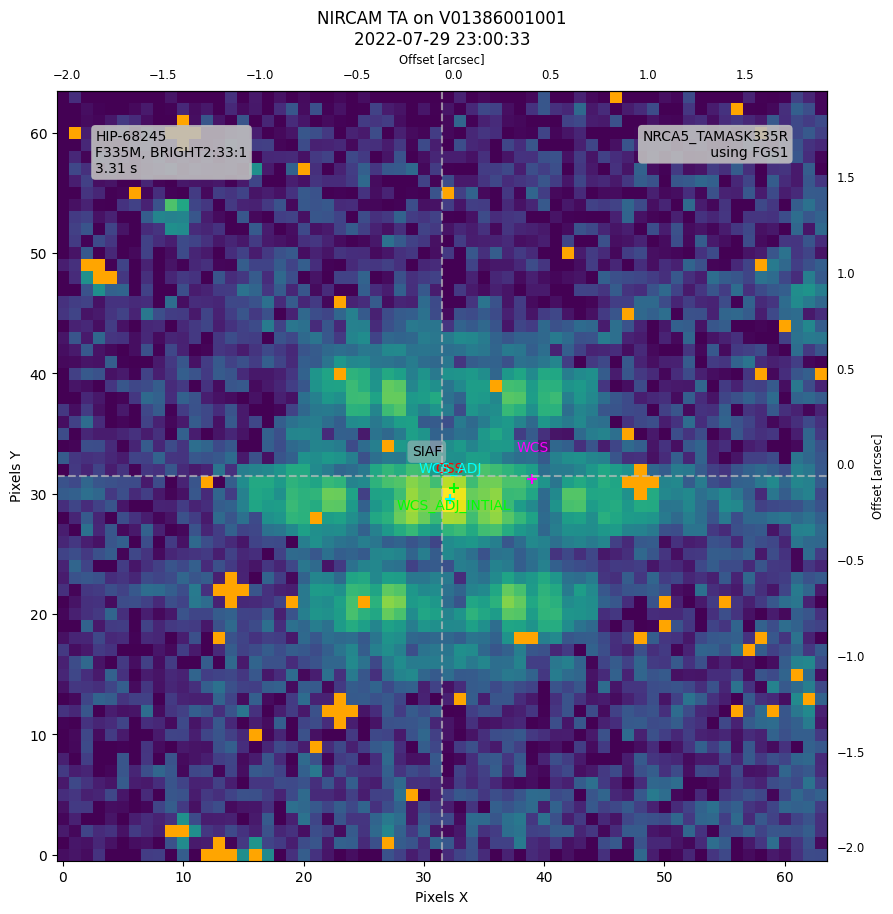

In [17]:
# Update the TA image with the Adjusted WCS target coordinate.
fig = ax.get_figure()
ax.scatter(targ_coords_pix_adj[0], targ_coords_pix_adj[1],
           color='cyan', marker='+', s=50)
ax.text(targ_coords_pix_adj[0], targ_coords_pix_adj[1] + 2, 'WCS_ADJ',
        color='cyan', verticalalignment='bottom',
        horizontalalignment='center')
fig

All of the above can be done calling the following function: 

Querying MAST for target acquisition files for visit V01386001001
Found 1 target acquisition image(s) for this observation.
TA file: jw01386001001_02102_00001_nrcalong_cal.fits
Extracted date and time: 2022-07-29 23:04:19.32
Datetime object: 2022-07-29 23:04:19.320000
TA Target coordinates (RA, Dec) [deg]: (209.567586, -42.100881)
TA Target (hms | dms): 13:58:16.22062338 -42:06:03.17243711
TA Target coordinates from WCS (x, y) [pix]: 39.022, 31.266
TA Target centroid coordinates (RA, Dec) [deg]: (209.567586, -42.100881)
OSS centroid on board (x, y):  (1557.8437, 1548.52431)  (full det coord frame, 1-based)
OSS centroid converted (x, y): [32.1563  29.52431]  (sci frame in NRCA5_TAMASK335R, 0-based)
OSS centroid converted (x, y): [ 490.1563  1547.52431]  (sci frame in NRCA5_FULL, 0-based)
TA WCS offset (x, y) [pix] =  7.578, 3.306 (WCS - OSS)
TA ΔRA, ΔDEC =  0.574 arcsec, 0.728 arcsec (WCS - OSS)
Adjusted TA Target coordinates (RA, Dec) [deg]: = 209.567586, -42.100881
TA Target coordinat

[149.32988205159018, 173.51000768375206]

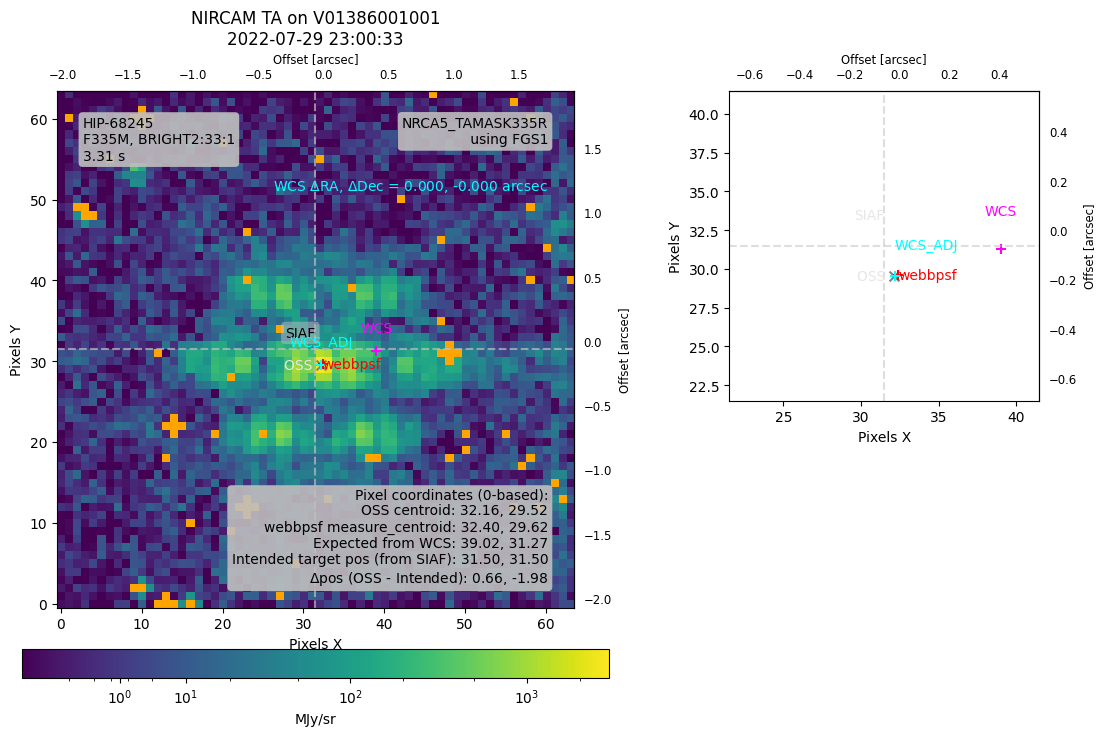

In [19]:
target_acq_tools.ta_analysis(cal_product,
                             inst=instrument,
                             verbose=True,
                             plot=True)

As a last check, let's plot the adjusted target coordinates in the SCI frame.

The SCI aperture is NRCA5_MASK335R


(149.0, 159.0)

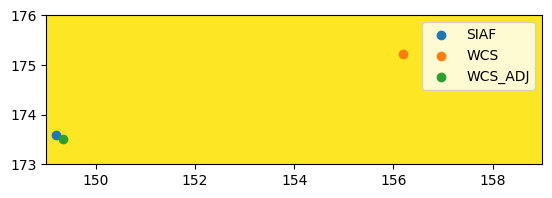

In [18]:
cal = datamodels.open(cal_product)
cal_data = cal.data[0]

sci_aperture = siaf.apertures[cal.meta.aperture.name]
xref_sci, yref_sci = sci_aperture.XSciRef - 1, sci_aperture.YSciRef - 1  # 1-indexed
print(f"The SCI aperture is {sci_aperture.AperName}")  # This should match the label in the plots above.

targ_coords_pix_sci = cal.meta.wcs.world_to_pixel(targ_coords)  # Returns (x, y).

plt.imshow(cal_data, vmin=np.nanpercentile(cal_data, 5), vmax=np.nanpercentile(cal_data, 80), origin='lower')
plt.scatter(xref_sci, yref_sci, label='SIAF')
plt.scatter(*targ_coords_pix_sci, label='WCS')
plt.scatter(targ_coords_pix_adj_sci[0], targ_coords_pix_adj_sci[1], label='WCS_ADJ')

plt.legend()
plt.ylim(173,176)
plt.xlim(149,159)